In [38]:
%pylab inline
import os
import pandas as pd
from collections import OrderedDict


Populating the interactive namespace from numpy and matplotlib


In [251]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sys
import time

PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":20,"axes.titlesize":22,
                       "axes.labelsize":22, 'axes.linewidth': 2,
                       "legend.fontsize":20, "xtick.labelsize": 20,
                       "ytick.labelsize":20, "xtick.major.size": 8.0,
                       "ytick.major.size": 8.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 20
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [195]:
cbbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

species_colors = {"GRCh38" : cbbPalette[5-1],
          "Mmul8" :  cbbPalette[6-1],
          "panTro3" : cbbPalette[7-1]}

species_colors_named = {"human" : cbbPalette[5-1],
                        "macaque" :  cbbPalette[6-1],
                        "chimpanzee" : cbbPalette[7-1]}

In [181]:
def get_extreme_gene(ribo_df, rna_df, ribo_col, rna_col):
    """Get extreme genes based on difference in rib/rna ratio.
    It filts a gaussian, but better to check explicitly everytime
    
    Parameters
    ----------
    ribo_df, rna_df: TPM matrices for Ribo- and RNA-seq
    ribo_col, rna_col: Name of Ribo and RNA-seq cols
    
    """
    difference = np.log10(ribo_df[ribo_col]+1) - np.log10(rna_df[rna_col]+1)
    difference_mean = np.mean(difference)
    difference_var = np.std(difference)
    difference_centered = (difference-difference_mean)/difference_var
    
    outliers = difference_centered[np.abs(difference_centered)> 2]
    return outliers, difference_centered

def r2(x, y):
    corr, p = scipy.stats.pearsonr(x, y)
    r2 = corr ** 2
    #return '{}(p={:0.2e})'.format(r2, p)#scipy.stats.pearsonr(x, y)[0] ** 2
    return r2, p


In [12]:
def get_extreme_gene_df(tpm_ribo, tpm_rna, ribo_rna_pairs):
    gene_df = pd.DataFrame()
    for ribo_rna_sample in ribo_rna_pairs:
        ribo_sample, rna_sample = ribo_rna_sample
        gene_list, difference_centered = get_extreme_gene(tpm_ribo,
                                                          tpm_rna, 
                                                          ribo_sample,
                                                          rna_sample)
        dataframe = pd.DataFrame(gene_list.index.tolist(), columns=['gene_id'])
        dataframe['{}_{}'.format(ribo_sample, rna_sample)] = gene_list.values.tolist()
        dataframe = dataframe.set_index('gene_id')
        gene_df = gene_df.join(dataframe, how='outer')
        #gene_df = gene_df.fillna(0)
    #col_length = len(gene_df.columns)
    #gene_df_mean = gene_df.mean(axis=1)
    
    return gene_df#, gene_df.loc[gene_df_mean>=0.66]
    


# Read Orthologs

In [5]:
orthologs_Mmul8 = pd.read_csv('../../re-ribo-smk/data//orthologs/human_macaque_ortholog.tsv', sep='\t')
orthologs_Mmul8 = orthologs_Mmul8[orthologs_Mmul8["Macaque homology type"] == "ortholog_one2one"][["Gene stable ID", "Macaque gene stable ID"]]
orthologs_Mmul8.columns = ["gene_id", "ortholog"]
orthologs_Mmul8 = orthologs_Mmul8.drop_duplicates().set_index('ortholog')

In [6]:
orthologs_Mmul8.head()

,gene_id
ortholog,
ENSMMUG00000028699,ENSG00000198888
ENSMMUG00000028695,ENSG00000198763
ENSMMUG00000028689,ENSG00000198804
ENSMMUG00000028686,ENSG00000198712
ENSMMUG00000028684,ENSG00000228253


In [7]:
orthologs_panTro3 = pd.read_csv('../../re-ribo-smk/data//orthologs/human_chimp_ortholog.tsv', sep='\t')

orthologs_panTro3 = orthologs_panTro3[orthologs_panTro3["Chimpanzee homology type"] == "ortholog_one2one"][["Gene stable ID", "Chimpanzee gene stable ID"]]
orthologs_panTro3.columns = ["gene_id", "ortholog"]
orthologs_panTro3 = orthologs_panTro3.drop_duplicates().set_index('ortholog')
orthologs_panTro3.head()

,gene_id
ortholog,
ENSPTRG00000042641,ENSG00000198888
ENSPTRG00000042626,ENSG00000198763
ENSPTRG00000042642,ENSG00000210127
ENSPTRG00000042657,ENSG00000198804
ENSPTRG00000042660,ENSG00000198712


In [8]:

three_way_ortholog = orthologs_panTro3.reset_index().set_index('gene_id').rename(columns={'ortholog': 'panTro3'}).join(orthologs_Mmul8.reset_index().set_index('gene_id').rename(columns={'ortholog': 'Mmul8'}), how='inner')
three_way_ortholog.head()

,panTro3,Mmul8
gene_id,,
ENSG00000198888,ENSPTRG00000042641,ENSMMUG00000028699
ENSG00000198763,ENSPTRG00000042626,ENSMMUG00000028695
ENSG00000198804,ENSPTRG00000042657,ENSMMUG00000028689
ENSG00000198712,ENSPTRG00000042660,ENSMMUG00000028686
ENSG00000228253,ENSPTRG00000042653,ENSMMUG00000028684


In [17]:
metadata = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-metadata/rna_ribo_metadata.tsv', sep='\t')

metadata_panTro3 = metadata[metadata.species=='panTro3']
ribo_rna_pairs_panTro3 = [('SRX1135820', 'SRX333022'),
                            ('SRX1135821', 'SRX333021'),
                          ('SRX1135822', 'SRX333020'),
                          ('SRX1135823', 'SRX333019'),
                          ('SRX1135824', 'SRX333018'),
                        ]
ribo_samples_panTro3 = list(sorted([x[0] for x in ribo_rna_pairs_panTro3]))
rna_samples_panTro3 = list(sorted([x[1] for x in ribo_rna_pairs_panTro3]))


metadata_GRCh38 = metadata[metadata.species=='GRCh38'].sort_values(by=['assay', 'sex'])
female_ribo = metadata_GRCh38.query("sex == 'female' and assay== 'ribo'").experiment_accession
female_rna = metadata_GRCh38.query("sex == 'female' and assay== 'rna'").experiment_accession
male_ribo = metadata_GRCh38.query("sex == 'male' and assay== 'ribo'").experiment_accession
male_rna = metadata_GRCh38.query("sex == 'male' and assay== 'rna'").experiment_accession
female_combinations = [(x,y) for x in female_ribo for y in female_rna]
male_combinations = [(x,y) for x in male_ribo for y in male_rna]
ribo_rna_pairs_GRCh38 = female_combinations + male_combinations
ribo_samples_GRCh38 = list(sorted([x[0] for x in ribo_rna_pairs_GRCh38]))
rna_samples_GRCh38 = list(sorted([x[1] for x in ribo_rna_pairs_GRCh38]))



metadata_Mmul8 = metadata[metadata.species=='Mmul8'].sort_values(by=['assay', 'sex', 'cell_line'])
ribo_rna_pairs_Mmul8 = list(zip(metadata_Mmul8.experiment_accession.tolist()[:5],
                                metadata_Mmul8.experiment_accession.tolist()[5:]))
ribo_samples_Mmul8 = list(sorted([x[0] for x in ribo_rna_pairs_Mmul8]))
rna_samples_Mmul8 = list(sorted([x[1] for x in ribo_rna_pairs_Mmul8]))


In [27]:
metadata

,experiment_accession,cell_line,species,sex,assay
0,SRX1135820,Min18358,panTro3,female,ribo
1,SRX1135821,Min18358,panTro3,female,ribo
2,SRX1135822,NS03659,panTro3,female,ribo
3,SRX1135823,NS04973,panTro3,male,ribo
4,SRX1135824,Pt91,panTro3,male,ribo
5,SRX1135825,150-99,Mmul8,female,ribo
6,SRX1135826,R181-96,Mmul8,male,ribo
7,SRX1135827,R249-97,Mmul8,male,ribo
8,SRX1135828,265-95,Mmul8,male,ribo
9,SRX1135829,R290-96,Mmul8,male,ribo


# Read Counts


In [24]:
uorf_raw_counts_df_hg38_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF_ribo.tsv', sep='\t')
cds_raw_counts_df_hg38_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo.tsv', sep='\t')

uorf_raw_counts_df_Mmul8_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_uORF_ribo.tsv', sep='\t')
cds_raw_counts_df_Mmul8_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_cds_ribo.tsv', sep='\t')

uorf_raw_counts_df_panTro3_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_uORF_ribo.tsv',  sep='\t')
cds_raw_counts_df_panTro3_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_cds_ribo.tsv',  sep='\t')

uorf_normalized_counts_df_hg38_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF_ribo_normalized.tsv', sep='\t')
cds_normalized_counts_df_hg38_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_ribo_normalized.tsv', sep='\t')

uorf_normalized_counts_df_Mmul8_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_uORF_ribo_normalized.tsv', sep='\t')
cds_normalized_counts_df_Mmul8_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_cds_ribo_normalized.tsv', sep='\t')

uorf_normalized_counts_df_panTro3_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_uORF_ribo_normalized.tsv',  sep='\t')
cds_normalized_counts_df_panTro3_ribo= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_cds_ribo_normalized.tsv',  sep='\t')

uorf_raw_counts_df_hg38_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF_rna.tsv', sep='\t')
cds_raw_counts_df_hg38_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_rna.tsv', sep='\t')

uorf_raw_counts_df_Mmul8_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_uORF_rna.tsv', sep='\t')
cds_raw_counts_df_Mmul8_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_cds_rna.tsv', sep='\t')

uorf_raw_counts_df_panTro3_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_uORF_rna.tsv',  sep='\t')
cds_raw_counts_df_panTro3_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_cds_rna.tsv',  sep='\t')

uorf_normalized_counts_df_hg38_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF_rna_normalized.tsv', sep='\t')
cds_normalized_counts_df_hg38_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_rna_normalized.tsv', sep='\t')

uorf_normalized_counts_df_Mmul8_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_uORF_rna_normalized.tsv', sep='\t')
cds_normalized_counts_df_Mmul8_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_cds_rna_normalized.tsv', sep='\t')

uorf_normalized_counts_df_panTro3_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_uORF_rna_normalized.tsv',  sep='\t')
cds_normalized_counts_df_panTro3_rna= pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_cds_rna_normalized.tsv',  sep='\t')

uorf_normalized_counts_df_hg38 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF_normalized.tsv',  sep='\t')
cds_normalized_counts_df_hg38 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds_normalized.tsv',  sep='\t')

uorf_normalized_counts_df_Mmul8 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_uORF_normalized.tsv',  sep='\t')
cds_normalized_counts_df_Mmul8 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_cds_normalized.tsv',  sep='\t')

uorf_normalized_counts_df_panTro3 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_uORF_normalized.tsv',  sep='\t')
cds_normalized_counts_df_panTro3 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_cds_normalized.tsv',  sep='\t')


uorf_raw_counts_df_hg38 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_uORF.tsv',  sep='\t')
cds_raw_counts_df_hg38 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/GRCh38_cds.tsv',  sep='\t')

uorf_raw_counts_df_Mmul8 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_uORF.tsv',  sep='\t')
cds_raw_counts_df_Mmul8 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/Mmul8_cds.tsv',  sep='\t')

uorf_raw_counts_df_panTro3 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_uORF.tsv',  sep='\t')
cds_raw_counts_df_panTro3 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-counts/panTro3_cds.tsv',  sep='\t')

In [61]:
def uorf_cds_ratio_TE(uorf_normalized_counts, cds_normalized_counts, ribo_rna_pairs):
    # TE
    total_difference_df = pd.DataFrame()
    for ribo_rna_sample in ribo_rna_pairs:
        ribo_sample, rna_sample = ribo_rna_sample
        uorf_difference = np.log10(uorf_normalized_counts[ribo_sample]) - np.log10(uorf_normalized_counts[rna_sample])
        cds_difference = np.log10(cds_normalized_counts[ribo_sample]) - np.log10(cds_normalized_counts[rna_sample])
        total_difference = cds_difference - uorf_difference
        colname = '{}_{}'.format(ribo_sample, rna_sample)
        diff_df  = pd.DataFrame(total_difference, columns=[colname])
        total_difference_df = total_difference_df.join(diff_df, how='outer')
    return total_difference_df

def uorf_cds_ratio_ribo(uorf_normalized_counts, cds_normalized_counts, ribo_rna_pairs):
    difference_df = pd.DataFrame()
    for ribo_rna_sample in ribo_rna_pairs:
        ribo_sample, rna_sample = ribo_rna_sample
        # Hacky way to keep consistnet loop by skipping ribo sampels
        if ribo_sample in difference_df.columns:
            continue
        difference = np.log10(cds_normalized_counts[ribo_sample]) - np.log10(uorf_normalized_counts[ribo_sample])
        colname = 'ribo_{}'.format(ribo_sample)
        diff_df  = pd.DataFrame(difference)#, columns=[colname])
        #print(diff_df.shape, pd.DataFrame(difference))
        difference_df = difference_df.join(diff_df, how='outer')
        
    return difference_df
def count_uorfs(df, filter_translating=True, filter_ATG=True):    
    df = df[df.ORF_type.isin(['uORF', 'super_uORF'])]
    if filter_ATG:
        df = df[df.start_codon == 'ATG']
    if filter_translating:
        df = df[df.status=='translating']
        
    gene_ids = pd.DataFrame(df.gene_id.value_counts())
    gene_ids.columns =['uORFs']
    return gene_ids


def read_ribotrcer_samples(root_path, ribo_samples):
    ribotricer_output = OrderedDict()
    for ribo_sample in ribo_samples:
        if ribo_sample in ribotricer_output.keys():
            continue
        print(ribo_sample)
        filepath = os.path.join(root_path, ribo_sample+'_translating_ORFs.tsv')
        ribotricer_output[ribo_sample] = pd.read_csv(filepath, sep='\t')
    return ribotricer_output

In [36]:
te_hg38 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-translational-efficiency/GRCh38_TE.tsv', sep='\t')
te_panTro3 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-translational-efficiency/panTro3_TE.tsv', sep='\t')
te_Mmul8 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-translational-efficiency/Mmul8_TE.tsv', sep='\t')



In [118]:
dORF_hg38 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-translational-efficiency/GRCh38_dORF.tsv', sep='\t')
dORF_panTro3 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-translational-efficiency/panTro3_dORF.tsv', sep='\t')
dORF_Mmul8 = pd.read_csv('../../re-ribo-smk/data/ortho-datasets-translational-efficiency/Mmul8_dORF.tsv', sep='\t')



In [41]:
ribotricer_output_hg38 = read_ribotrcer_samples('/staging/as/skchoudh/re-ribo-analysis/hg38/SRP062129/ribotricer_results/', 
                                                ribo_samples_GRCh38)

ribotricer_output_panTro3 = read_ribotrcer_samples('/staging/as/skchoudh/re-ribo-analysis/panTro3/SRP062129/ribotricer_results/', 
                                                   ribo_samples_panTro3)
ribotricer_output_Mmul8 = read_ribotrcer_samples('/staging/as/skchoudh/re-ribo-analysis/Mmul8/SRP062129/ribotricer_results/', 
                                               ribo_samples_Mmul8)

SRX2786686


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


SRX2786687
SRX2786688
SRX2786689
SRX1135820
SRX1135821
SRX1135822
SRX1135823
SRX1135824
SRX1135825
SRX1135826
SRX1135827
SRX1135828
SRX1135829


In [96]:
def count_orfs_across_samples(ribotricer_output_dict,filter_translating=True, filter_ATG=True):
    master_df = pd.DataFrame()
    for sample, df in ribotricer_output_dict.items():
        norfs = count_uorfs(df, filter_translating, filter_ATG)
        norfs.columns = [sample]
        master_df = master_df.join(norfs, how='outer')
    return master_df.fillna(0)
        
def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return (x,y)        

In [113]:
xlabel= 'CDS TE (log2)'

/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.0272192891533162e-14
0.14419593530782532


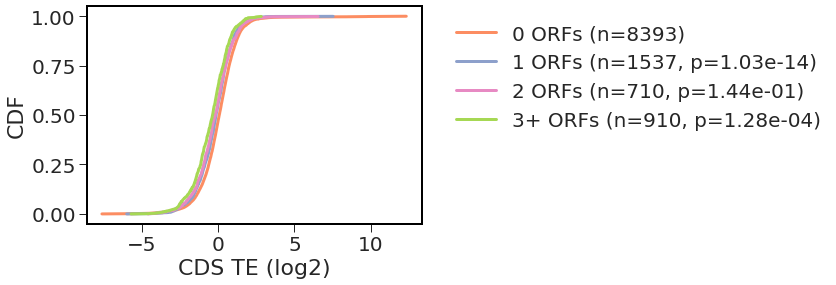

In [253]:
norfs_translating_hg38 = count_orfs_across_samples(ribotricer_output_hg38, False, True)
norfs_translating_hg38['mean_uORFs'] = norfs_translating_hg38.mean(axis=1)
norfs_translating_hg38['median_uORFs'] = norfs_translating_hg38.median(axis=1)
te_hg38_norfs = te_hg38[['log2FoldChange']].join(norfs_translating_hg38[['mean_uORFs', 'median_uORFs']])
te_hg38_norfs = te_hg38_norfs.fillna(0)
fig = plt.figure(figsize=(6, 4))
colors = ['#74c476', '#41ab5d', '#238b45', '#005a32']
for n_uorf in range(0,4):
    if n_uorf == 3:
        te_hg38_norfs_subset = te_hg38_norfs[te_hg38_norfs.median_uORFs >= n_uorf]
        x,y = cdf(te_hg38_norfs_subset.log2FoldChange)        

        pvalue = scipy.stats.mannwhitneyu(te_hg38_norfs_subset.log2FoldChange, y_prev)[1]
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],
                 label='{}+ ORFs (n={}, p={:0.2e})'.format(n_uorf, te_hg38_norfs_subset.shape[0], pvalue), linewidth=3)

        #sns.kdeplot(te_hg38_norfs_subset.log2FoldChange, 
        #                color=sns.color_palette('Set2')[n_uorf+1],#colors[n_uorf],
        #                label='{}+ ORFs (n={}, p={:0.2e})'.format(n_uorf, te_hg38_norfs_subset.shape[0], pvalue), 
        #                cumulative=True)#'{:0.3e}'.format(
        break

    te_hg38_norfs_subset = te_hg38_norfs[te_hg38_norfs.median_uORFs >= n_uorf]
    te_hg38_norfs_subset = te_hg38_norfs_subset[te_hg38_norfs.median_uORFs < n_uorf +1]
    x,y = cdf(te_hg38_norfs_subset.log2FoldChange)        

    if n_uorf>0:
        pvalue = scipy.stats.mannwhitneyu(te_hg38_norfs_subset.log2FoldChange, y_prev)[1]
        print(pvalue)
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],
                 label='{} ORFs (n={}, p={:0.2e})'.format(n_uorf, te_hg38_norfs_subset.shape[0], pvalue), linewidth=3)
                 
    else:
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],                 
                 label='{} ORFs (n={})'.format(n_uorf, te_hg38_norfs_subset.shape[0]), linewidth=3)
    y_prev = te_hg38_norfs_subset.log2FoldChange
        
    #print(n_uorf, te_hg38_norfs_subset.shape[0])
    #sns.kdeplot(te_hg38_norfs_subset.log2FoldChange, 
    #            color=sns.color_palette('Set2')[n_uorf+1],#colors[n_uorf],
    #            label='{} ORFs'.format(n_uorf), 
    #            cumulative=True)

plt.legend(loc=2, bbox_to_anchor=(1.05, 1), frameon=False)
plt.xlabel(xlabel)
plt.ylabel("CDF")
fig.savefig("../../re-ribo-smk/plots/GRCh38/GRCh38_TE_vs_n_uORF_CDF.pdf", dpi="figure", bbox_inches="tight")


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.07802977332654659
0.02088953340070726


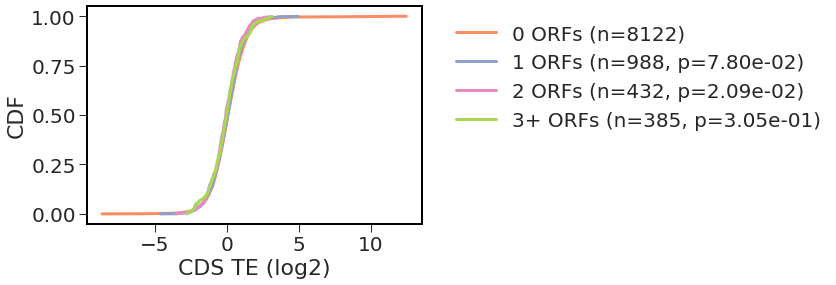

In [273]:
norfs_translating_panTro3 = count_orfs_across_samples(ribotricer_output_panTro3, False, True)
norfs_translating_panTro3['mean_uORFs'] = norfs_translating_panTro3.mean(axis=1)
norfs_translating_panTro3['median_uORFs'] = norfs_translating_panTro3.median(axis=1)
te_panTro3_norfs = te_panTro3[['log2FoldChange']].join(norfs_translating_panTro3[['mean_uORFs', 'median_uORFs']])
te_panTro3_norfs = te_panTro3_norfs.fillna(0)
fig = plt.figure(figsize=(6,4))
colors = ['#74c476', '#41ab5d', '#238b45', '#005a32']
for n_uorf in range(0,4):
    if n_uorf == 3:
        te_panTro3_norfs_subset = te_panTro3_norfs[te_panTro3_norfs.median_uORFs >= n_uorf]
        x,y = cdf(te_panTro3_norfs_subset.log2FoldChange)        

        pvalue = scipy.stats.mannwhitneyu(te_panTro3_norfs_subset.log2FoldChange, y_prev)[1]
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],
                 label='{}+ ORFs (n={}, p={:0.2e})'.format(n_uorf, te_panTro3_norfs_subset.shape[0], pvalue), linewidth=3)

        #sns.kdeplot(te_panTro3_norfs_subset.log2FoldChange, 
        #                color=sns.color_palette('Set2')[n_uorf+1],#colors[n_uorf],
        #                label='{}+ ORFs (n={}, p={:0.2e})'.format(n_uorf, te_panTro3_norfs_subset.shape[0], pvalue), 
        #                cumulative=True)#'{:0.3e}'.format(
        break

    te_panTro3_norfs_subset = te_panTro3_norfs[te_panTro3_norfs.median_uORFs >= n_uorf]
    te_panTro3_norfs_subset = te_panTro3_norfs_subset[te_panTro3_norfs.median_uORFs < n_uorf +1]
    x,y = cdf(te_panTro3_norfs_subset.log2FoldChange)        

    if n_uorf>0:
        pvalue = scipy.stats.mannwhitneyu(te_panTro3_norfs_subset.log2FoldChange, y_prev)[1]
        print(pvalue)
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],
                 label='{} ORFs (n={}, p={:0.2e})'.format(n_uorf, te_panTro3_norfs_subset.shape[0], pvalue), linewidth=3)
                 
    else:
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],                 
                 label='{} ORFs (n={})'.format(n_uorf, te_panTro3_norfs_subset.shape[0]), linewidth=3)
    y_prev = te_panTro3_norfs_subset.log2FoldChange
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), frameon=False)
plt.xlabel(xlabel)
plt.ylabel("CDF")
fig.savefig("../../re-ribo-smk/plots/panTro3/panTro3_TE_vs_n_uORF_CDF.pdf", dpi="figure", bbox_inches="tight")


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1.999522032117776e-09
0.21341468780474898


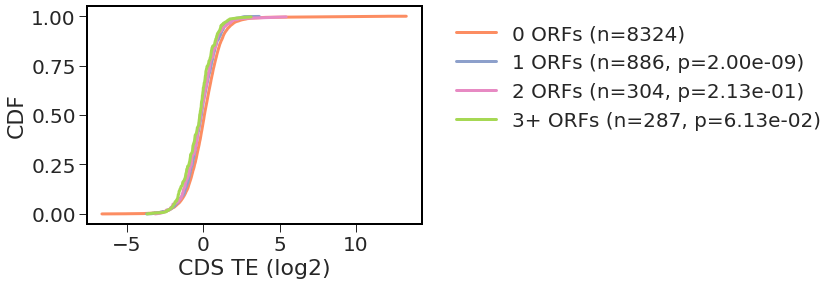

In [274]:
norfs_translating_Mmul8 = count_orfs_across_samples(ribotricer_output_Mmul8, False, True)
norfs_translating_Mmul8['mean_uORFs'] = norfs_translating_Mmul8.mean(axis=1)
norfs_translating_Mmul8['median_uORFs'] = norfs_translating_Mmul8.median(axis=1)
te_Mmul8_norfs = te_Mmul8[['log2FoldChange']].join(norfs_translating_Mmul8[['mean_uORFs', 'median_uORFs']])
te_Mmul8_norfs = te_Mmul8_norfs.fillna(0)
fig = plt.figure(figsize=(6,4))
colors = ['#74c476', '#41ab5d', '#238b45', '#005a32']
for n_uorf in range(0,4):
    if n_uorf == 3:
        te_Mmul8_norfs_subset = te_Mmul8_norfs[te_Mmul8_norfs.median_uORFs >= n_uorf]
        x,y = cdf(te_Mmul8_norfs_subset.log2FoldChange)        

        pvalue = scipy.stats.mannwhitneyu(te_Mmul8_norfs_subset.log2FoldChange, y_prev)[1]
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],
                 label='{}+ ORFs (n={}, p={:0.2e})'.format(n_uorf, te_Mmul8_norfs_subset.shape[0], pvalue), linewidth=3)

        #sns.kdeplot(te_Mmul8_norfs_subset.log2FoldChange, 
        #                color=sns.color_palette('Set2')[n_uorf+1],#colors[n_uorf],
        #                label='{}+ ORFs (n={}, p={:0.2e})'.format(n_uorf, te_Mmul8_norfs_subset.shape[0], pvalue), 
        #                cumulative=True)#'{:0.3e}'.format(
        break

    te_Mmul8_norfs_subset = te_Mmul8_norfs[te_Mmul8_norfs.median_uORFs >= n_uorf]
    te_Mmul8_norfs_subset = te_Mmul8_norfs_subset[te_Mmul8_norfs.median_uORFs < n_uorf +1]
    x,y = cdf(te_Mmul8_norfs_subset.log2FoldChange)        

    if n_uorf>0:
        pvalue = scipy.stats.mannwhitneyu(te_Mmul8_norfs_subset.log2FoldChange, y_prev)[1]
        print(pvalue)
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],
                 label='{} ORFs (n={}, p={:0.2e})'.format(n_uorf, te_Mmul8_norfs_subset.shape[0], pvalue), linewidth=3)
                 
    else:
        plt.plot(x, y,
                 color=sns.color_palette('Set2')[n_uorf+1],                 
                 label='{} ORFs (n={})'.format(n_uorf, te_Mmul8_norfs_subset.shape[0]), linewidth=3)
    y_prev = te_Mmul8_norfs_subset.log2FoldChange
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), frameon=False)
plt.xlabel(xlabel)
plt.ylabel("CDF")
fig.savefig("../../re-ribo-smk/plots/Mmul8/Mmul8_TE_vs_n_uORF_CDF.pdf", dpi="figure", bbox_inches="tight")


In [120]:
combined_df = dORF_hg38[['log2FoldChange']].rename(columns={'log2FoldChange': 'uORF TE(log2)'}).join(te_hg38[['log2FoldChange']].rename(columns={'log2FoldChange': 'CDS TE(log2)'}))

In [124]:
uorf_cds_ratio_ribo

<function __main__.uorf_cds_ratio_ribo(uorf_normalized_counts, cds_normalized_counts, ribo_rna_pairs)>

/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


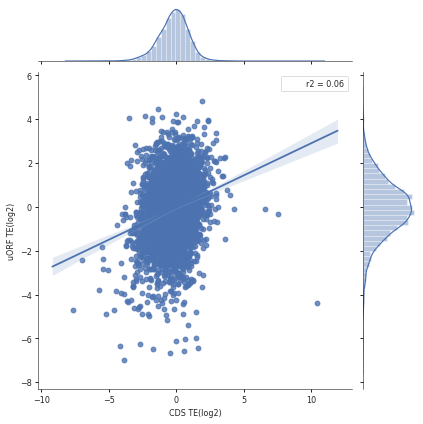

In [123]:
sns.jointplot(combined_df['CDS TE(log2)'], combined_df['uORF TE(log2)'], kind="reg",  stat_func=r2)

In [132]:
cds_uorf_diff_ribo_rawcounts_hg38 = uorf_cds_ratio_ribo(1+uorf_raw_counts_df_hg38.set_index('gene_id'), 
                                    1+cds_raw_counts_df_hg38.set_index('gene_id'), 
                                    ribo_rna_pairs_GRCh38)
cds_uorf_diff_ribo_rawcounts_panTro3 = uorf_cds_ratio_ribo(1+uorf_raw_counts_df_panTro3.set_index('gene_id'), 
                                    1+cds_raw_counts_df_panTro3.set_index('gene_id'), 
                                    ribo_rna_pairs_panTro3)
cds_uorf_diff_ribo_rawcounts_Mmul8 = uorf_cds_ratio_ribo(1+uorf_raw_counts_df_Mmul8.set_index('gene_id'), 
                                    1+cds_raw_counts_df_Mmul8.set_index('gene_id'), 
                                    ribo_rna_pairs_Mmul8)

cds_uorf_diff_ribo_rawcounts_hg38 = np.power(cds_uorf_diff_ribo_rawcounts_hg38, 10)
cds_uorf_diff_ribo_rawcounts_panTro3 = np.power(cds_uorf_diff_ribo_rawcounts_panTro3, 10)

cds_uorf_diff_ribo_rawcounts_Mmul8 = np.power(cds_uorf_diff_ribo_rawcounts_Mmul8, 10)

In [140]:
#np.log2(cds_uorf_diff_ribo_rawcounts_hg38.mean(axis=1, skipna=True).dropna())
cds_uorf_diff_ribo_rawcounts_hg38_mean = np.log2(pd.DataFrame(cds_uorf_diff_ribo_rawcounts_hg38.mean(axis=1), columns=['uORF_CDS_ratio']))
cds_uorf_diff_ribo_rawcounts_hg38_mean = cds_uorf_diff_ribo_rawcounts_hg38_mean[np.isfinite(cds_uorf_diff_ribo_rawcounts_hg38_mean).all(1)]

/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


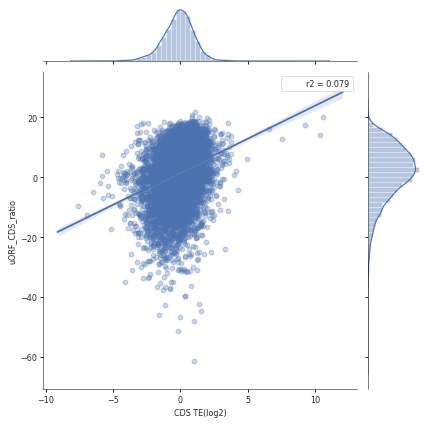

In [142]:
cds_uorf_diff_ribo_rawcounts_hg38_mean
combined_df = cds_uorf_diff_ribo_rawcounts_hg38_mean.join(te_hg38[['log2FoldChange']].rename(columns={'log2FoldChange': 'CDS TE(log2)'}))
g = sns.jointplot(combined_df['CDS TE(log2)'], combined_df['uORF_CDS_ratio'], kind="reg",  stat_func=r2)
g.ax_joint.collections[0].set_alpha(0.3)


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


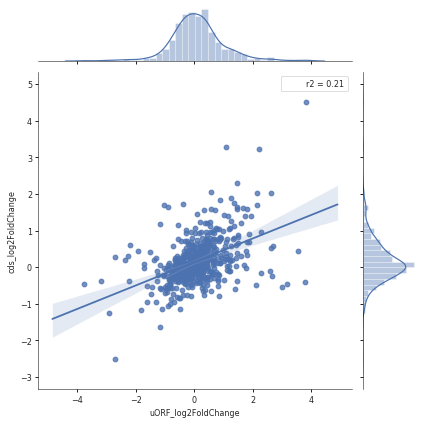

In [143]:
uorf_deseq_panTro3vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/panTro3_GRCh38_uorf_ribo_ortho_allthree.tsv', sep='\t').rename(columns={'log2FoldChange': 'uORF_log2FoldChange'})
cds_deseq_panTro3vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/panTro3_GRCh38_cds_ribo_ortho_allthree.tsv', sep='\t')
cds_deseq_panTro3vsGRCh38 = cds_deseq_panTro3vsGRCh38.rename(columns={'log2FoldChange': 'cds_log2FoldChange'})
combined_df = uorf_deseq_panTro3vsGRCh38[['uORF_log2FoldChange']].join(cds_deseq_panTro3vsGRCh38[['cds_log2FoldChange']]).dropna()
sns.jointplot(combined_df['uORF_log2FoldChange'], combined_df['cds_log2FoldChange'], kind="reg",  stat_func=r2)


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
No handles with labels found to put in legend.


<Figure size 432x432 with 0 Axes>

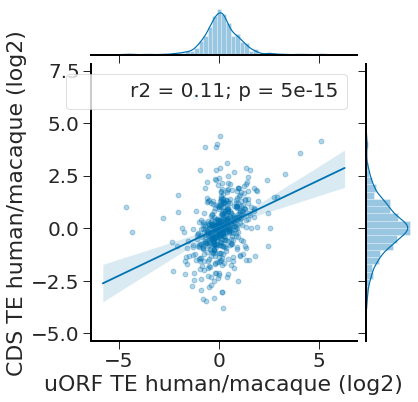

In [249]:
uorf_deseq_Mmul8vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/Mmul8_GRCh38_uorf_ribo_ortho_allthree.tsv', sep='\t').rename(columns={'log2FoldChange': 'uORF_log2FoldChange'})
cds_deseq_Mmul8vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/Mmul8_GRCh38_cds_ribo_ortho_allthree.tsv', sep='\t')
cds_deseq_Mmul8vsGRCh38 = cds_deseq_Mmul8vsGRCh38.rename(columns={'log2FoldChange': 'cds_log2FoldChange'})
combined_df = uorf_deseq_Mmul8vsGRCh38[['uORF_log2FoldChange']].join(cds_deseq_Mmul8vsGRCh38[['cds_log2FoldChange']]).dropna()
fig = plt.figure(figsize=(6,6))

g = sns.jointplot(combined_df['cds_log2FoldChange'], combined_df['uORF_log2FoldChange'], kind="reg",  stat_func=r2, color=species_colors["Mmul8"])
g.ax_joint.collections[0].set_alpha(0.3)
fig.legend(frameon=False)
#plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.xlabel('uORF TE human/macaque (log2)')
plt.ylabel('CDS TE human/macaque (log2)')
g.savefig("../../re-ribo-smk/plots/Mmul8/Mmul8_uORF_CDS_ratio_vs_GRCh38.pdf")#, dpi="figure", bbox_inches="tight")


/home/cmb-06/as/skchoudh/software_frozen/anaconda37/envs/riboraptor/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 576x576 with 0 Axes>

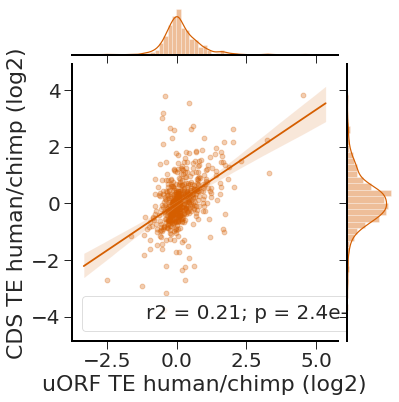

In [248]:


uorf_deseq_panTro3vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/panTro3_GRCh38_uorf_ribo_ortho_allthree.tsv', sep='\t').rename(columns={'log2FoldChange': 'uORF_log2FoldChange'})
cds_deseq_panTro3vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/panTro3_GRCh38_cds_ribo_ortho_allthree.tsv', sep='\t')
cds_deseq_panTro3vsGRCh38 = cds_deseq_panTro3vsGRCh38.rename(columns={'log2FoldChange': 'cds_log2FoldChange'})
combined_df = uorf_deseq_panTro3vsGRCh38[['uORF_log2FoldChange']].join(cds_deseq_panTro3vsGRCh38[['cds_log2FoldChange']]).dropna()
fig = plt.figure(figsize=(8,8))
g = sns.jointplot(combined_df['cds_log2FoldChange'], combined_df['uORF_log2FoldChange'], kind="reg",  stat_func=r2, color=species_colors["panTro3"])# legend_out=False)
g.ax_joint.collections[0].set_alpha(0.3)

#plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.xlabel('uORF TE human/chimp (log2)')
plt.ylabel('CDS TE human/chimp (log2)')
#plt.legend(loc='upper left')

g.savefig("../../re-ribo-smk/plots/panTro3/panTro3_uORF_CDS_ratio_vs_GRCh38.pdf")# dpi="figure", bbox_inches="tight")


In [275]:
np.sqrt(0.21)

0.458257569495584

In [276]:
np.sqrt(0.11)

0.33166247903553997

# Bar plots

In [237]:
cds_deseq_panTro3vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/panTro3_GRCh38_TE_ortho_allthree.sig.tsv', sep='\t')
cds_deseq_panTro3vsGRCh38.shape

(180, 7)

In [238]:
cds_deseq_Mmul8vsGRCh38 = pd.read_csv('/home/cmb-panasas2/skchoudh/github_projects/re-ribo-smk/data/ortho-differential-analysis/Mmul8_GRCh38_TE_ortho_allthree.sig.tsv', sep='\t')
cds_deseq_Mmul8vsGRCh38.shape

(475, 7)

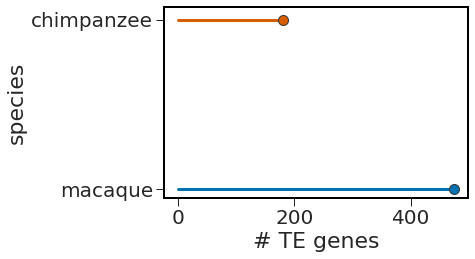

In [239]:
data = pd.DataFrame([('chimpanzee', cds_deseq_panTro3vsGRCh38.shape[0]), ('macaque', cds_deseq_Mmul8vsGRCh38.shape[0])])
data.columns = ['species', '# TE genes']
fig, ax = plt.subplots(figsize=(7,4))
sns.stripplot(y='species', x='# TE genes', palette=species_colors_named,data=data, size=10, marker="o", linewidth=1,
                  jitter=False, ax=ax)
for j, ylabel in enumerate(data.species):
        xval = data[data["species"] == ylabel]["# TE genes"].iloc[0]
        ax.plot([0, xval], [j, j], '-', linewidth=3, linestyle="solid", 
                 color=species_colors_named[ylabel])
fig.tight_layout()        
fig.savefig("../../re-ribo-smk/plots/Mmul8_PanTro3_GRCh38_TE_genes_bar.pdf")#, dpi="figure", bbox_inches="tight")
        

In [256]:
def get_common_ortholog_series_Mmul8(mmul8_series, hg38_series):
    """PLot values for mmul8 and hg 38 series for orthologous genes """
    #mmul8_shared_genes = do_intersection(orthologs_Mmul8.index, mmul8_series.index)
    #hg38_shared_genes = do_intersection(orthologs_Mmul8.ortholog, hg38_series.index)
    subsetted_values = []
    for idx, row in orthologs_Mmul8.iterrows():
        if idx in mmul8_series.index and row.gene_id in hg38_series.index:
            subsetted_values.append((idx, mmul8_series[idx], hg38_series[row.gene_id ]))
            
    return pd.DataFrame(subsetted_values, columns=['gene_id', 'Mmul8', 'GRCh38']).set_index('gene_id')

def get_common_ortholog_series_panTro3(panTro3_series, hg38_series):
    """PLot values for panTro3 and hg 38 series for orthologous genes """
    #panTro3_shared_genes = do_intersection(orthologs_panTro3.index, panTro3_series.index)
    #hg38_shared_genes = do_intersection(orthologs_panTro3.ortholog, hg38_series.index)
    subsetted_values = []
    for idx, row in orthologs_panTro3.iterrows():
        if idx in panTro3_series.index and row.gene_id in hg38_series.index:
            subsetted_values.append((idx, panTro3_series[idx], hg38_series[row.gene_id ]))
            
    return pd.DataFrame(subsetted_values, columns=['gene_id', 'panTro3', 'GRCh38']).set_index('gene_id')

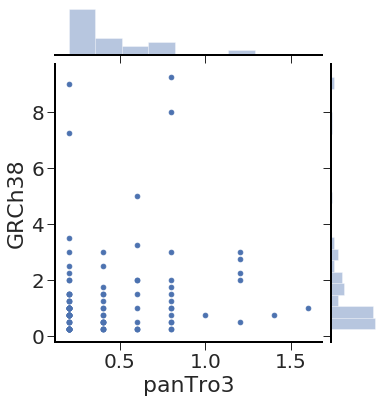

In [269]:
norfs_translating_panTro3 = count_orfs_across_samples(ribotricer_output_panTro3, True, True)
norfs_translating_panTro3['mean_uORFs'] = norfs_translating_panTro3.mean(axis=1)
norfs_translating_panTro3['median_uORFs'] = norfs_translating_panTro3.median(axis=1)

norfs_translating_hg38 = count_orfs_across_samples(ribotricer_output_hg38, True, True)
norfs_translating_hg38['mean_uORFs'] = norfs_translating_hg38.mean(axis=1)
norfs_translating_hg38['median_uORFs'] = norfs_translating_hg38.median(axis=1)


n_uorfs_pantro3_common = get_common_ortholog_series_panTro3(norfs_translating_panTro3['mean_uORFs'], norfs_translating_hg38['mean_uORFs'])
sns.jointplot(n_uorfs_pantro3_common.panTro3, n_uorfs_pantro3_common.GRCh38)

In [270]:
norfs_translating_panTro3.head()

,SRX1135820,SRX1135821,SRX1135822,SRX1135823,SRX1135824,mean_uORFs,median_uORFs
ENSPTRG00000000563,0.0,0.0,1.0,0.0,0.0,0.2,0.0
ENSPTRG00000000573,0.0,0.0,0.0,0.0,2.0,0.4,0.0
ENSPTRG00000000644,0.0,0.0,4.0,0.0,0.0,0.8,0.0
ENSPTRG00000000739,0.0,0.0,1.0,1.0,0.0,0.4,0.2
ENSPTRG00000000759,0.0,0.0,1.0,0.0,0.0,0.2,0.0


In [271]:
norfs_translating_hg38.head()

,SRX2786686,SRX2786687,SRX2786688,SRX2786689,mean_uORFs,median_uORFs
ENSG00000000938,0.0,2.0,2.0,0.0,1.00,1.00
ENSG00000001461,4.0,4.0,0.0,4.0,3.00,4.00
ENSG00000002822,0.0,0.0,4.0,4.0,2.00,2.00
ENSG00000002919,2.0,1.0,0.0,2.0,1.25,1.25
ENSG00000003056,1.0,1.0,1.0,0.0,0.75,1.00


In [261]:
n_uorfs.shape

(1096, 2)